In [9]:
from liblibra_core import *
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma
from math import log, pi, gamma

from commons import kozachenko_leonenko_entropy
from commons import show_hist
from commons import compute_informations


In [10]:
rnd = Random()

# 1. Integral measure

In [11]:
t, accum0, accum1, accum2 = [], [], [], []
k0, k1, k2 = [], [], []

sum0, sum1, sum2 = 0.0, 0.0, 0.0

for i in range(5000):
    t.append(i)
    
    # Regular case - error's variance is fixed
    x = rnd.normal()
    sum0 += x**2
    k0.append(sum0/(i+1))
    
    # Variance increase over time
    x = rnd.normal() * (1.0 - np.exp(-i/500))
    sum1 += x**2
    k1.append(sum1/(i+1))
    
    # Variance decrease over times
    x = rnd.normal() * np.exp(-i/500)
    sum2 += x**2
    k2.append(sum2/(i+1))
    
    accum0.append(sum0)
    accum1.append(sum1)
    accum2.append(sum2)
    

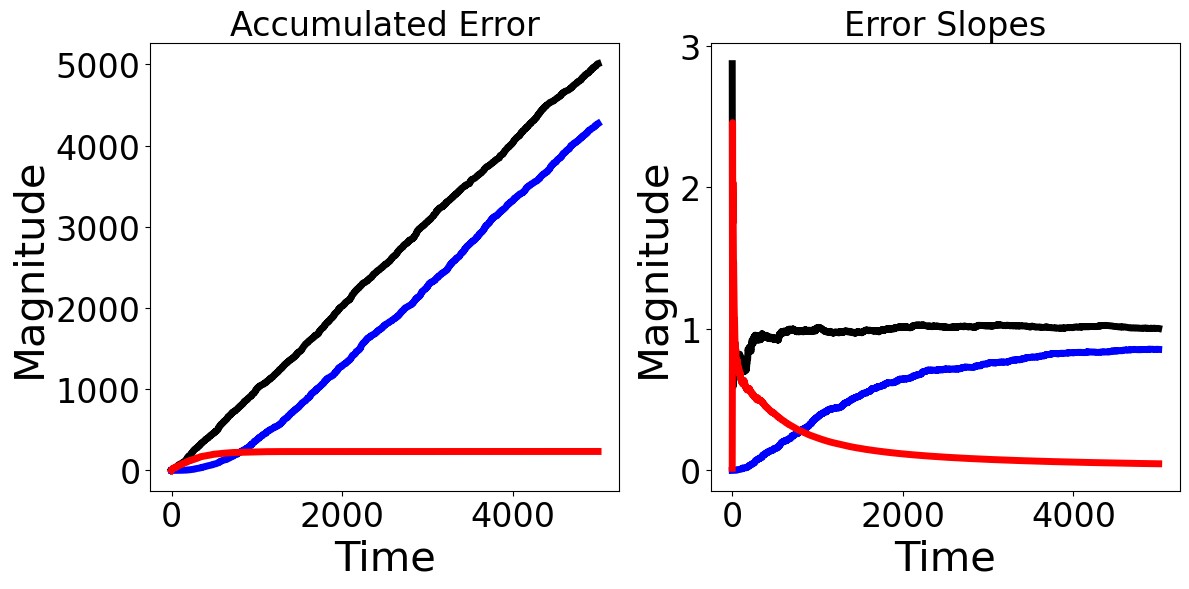

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title("Accumulated Error")
axes[0].set_xlabel("Time", fontsize=30)
axes[0].set_ylabel('Magnitude', fontsize=30)

axes[0].plot(t, accum0, label = "Constant", color = "black", lw =5)
axes[0].plot(t, accum1, label = "Increasing", color = "blue", lw =5)
axes[0].plot(t, accum2, label = "Decreasing", color = "red", lw =5)

axes[1].set_title("Error Slopes")
axes[1].set_xlabel("Time", fontsize=30)
axes[1].set_ylabel('Magnitude', fontsize=30)

axes[1].plot(t, k0, label = "Constant", color = "black", lw =5)
axes[1].plot(t, k1, label = "Increasing", color = "blue", lw =5)
axes[1].plot(t, k2, label = "Decreasing", color = "red", lw =5)

plt.tight_layout()

# 2. Informational measure

## 2.1. Random distribution of errors - demonstration of Shannon and KL Informations

In [13]:
t, x, x2 = [], [], []
for i in range(500):
    t.append(i)
    ksi = rnd.uniform(0.0, 0.1)
    ksi2 = rnd.uniform(0.0, 1.0)
    x.append(ksi)
    x2.append(ksi2)

H (from hist) = 0.006441531121436295 bits
H (from KDE) = 0.006464970221044769 bits
Kozachenko-Leonenko entropy ≈ -3.305559690244789 bits
H (from hist) = 0.06459471552544559 bits
H (from KDE) = 0.06460283085222529 bits
Kozachenko-Leonenko entropy ≈ 0.005606425168607954 bits


/tmp/ipykernel_230712/2478120487.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0,0].legend()
/tmp/ipykernel_230712/2478120487.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1,0].legend()


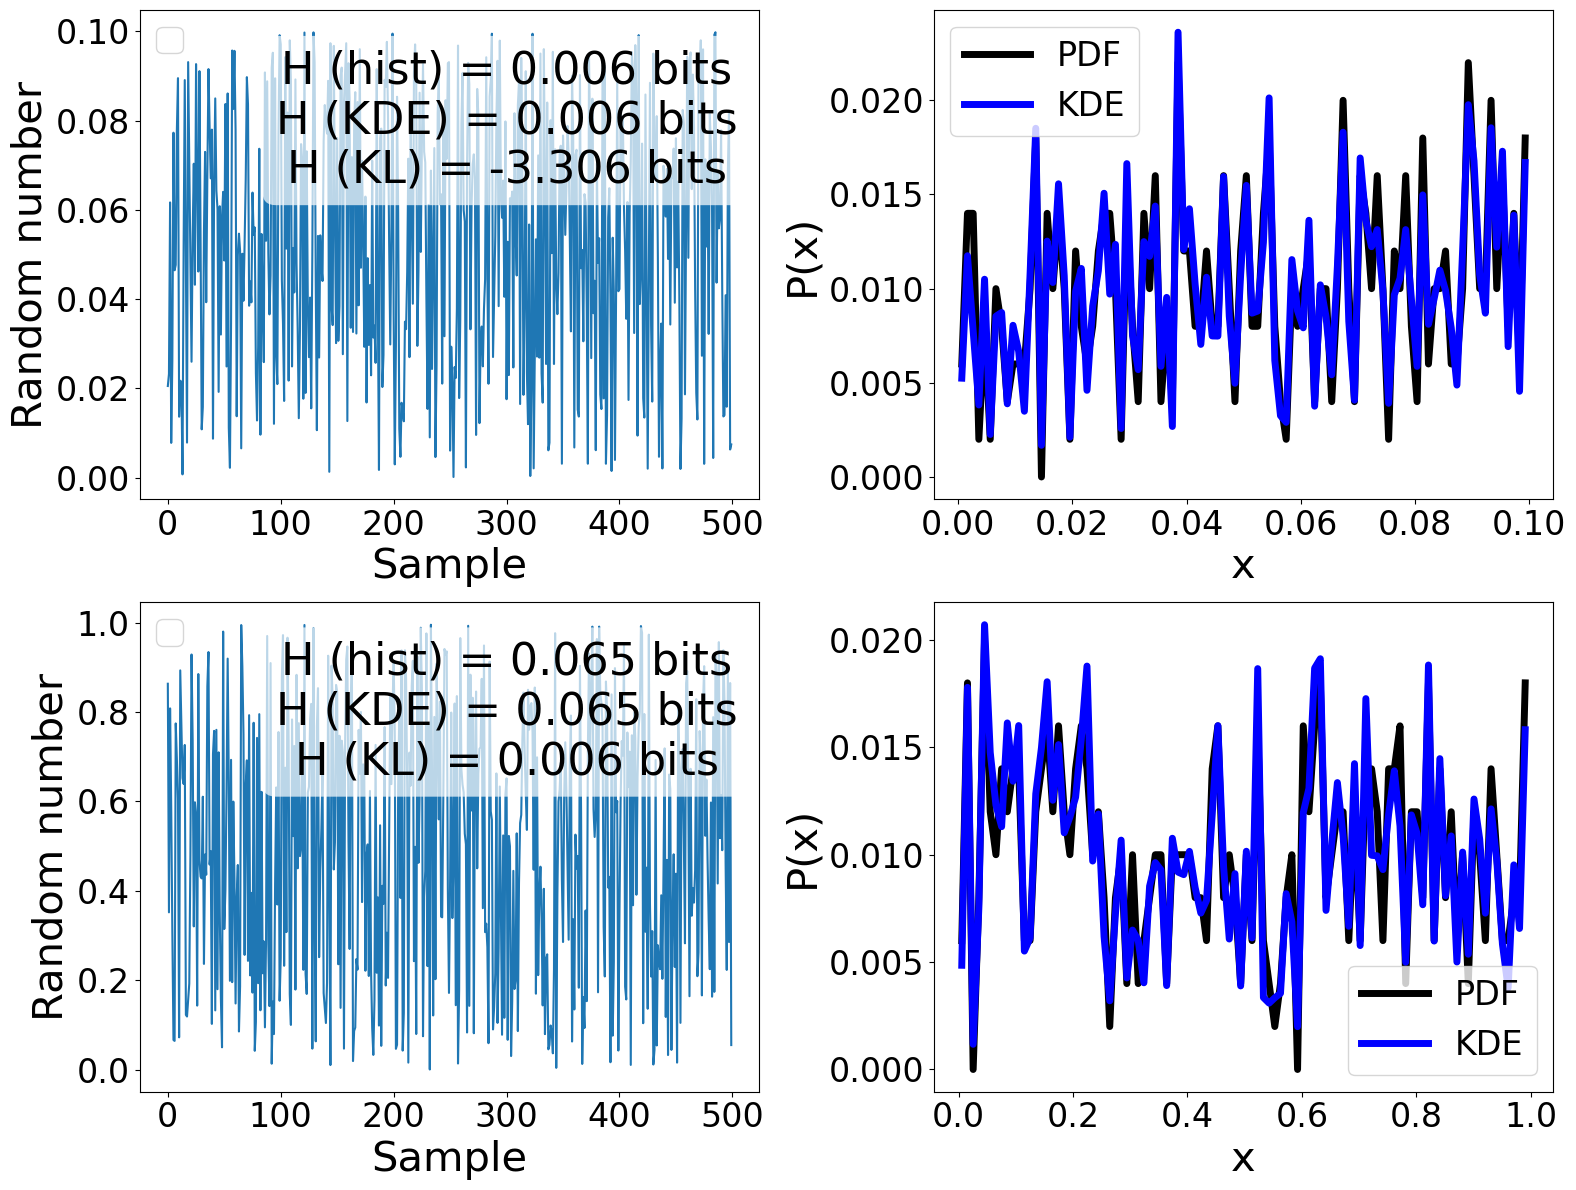

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
v1, v2, v3, px, counts, kde = compute_informations(x, bins=100, sigma=0.01)
axes[0,0].plot(t, x)
axes[0,1].plot(px, counts, label="PDF", lw=5, color="black")
axes[0,1].plot(px, kde, label="KDE", lw=5, color="blue")

text = f"H (hist) = {v1:.3f} bits\nH (KDE) = {v2:.3f} bits\nH (KL) = {v3:.3f} bits"
axes[0,0].text(300.0, 0.08, text, 
        color='black', fontsize=32, ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round'))
axes[0,0].legend()
axes[0,1].legend()
#axes[0,0].set_title('Sample')
axes[0,0].set_xlabel('Sample', fontsize=30)
axes[0,0].set_ylabel('Random number', fontsize=30)
axes[0,1].set_xlabel('x', fontsize=30)
axes[0,1].set_ylabel('P(x)', fontsize=30)


v1, v2, v3, px, counts, kde = compute_informations(x2, bins=100, sigma=0.01)
axes[1,0].plot(t, x2)
axes[1,1].plot(px, counts, label="PDF", lw=5, color="black")
axes[1,1].plot(px, kde, label="KDE", lw=5, color="blue")
axes[1,0].set_xlabel('Sample', fontsize=30)
axes[1,0].set_ylabel('Random number', fontsize=30)
axes[1,1].set_xlabel('x', fontsize=30)
axes[1,1].set_ylabel('P(x)', fontsize=30)


text = f"H (hist) = {v1:.3f} bits\nH (KDE) = {v2:.3f} bits\nH (KL) = {v3:.3f} bits"
axes[1,0].text(300.0, 0.8, text, 
        color='black', fontsize=32, ha='center', va='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round'))
axes[1,0].legend()
axes[1,1].legend()

plt.tight_layout()

## 2.2. Convergence of Information measures

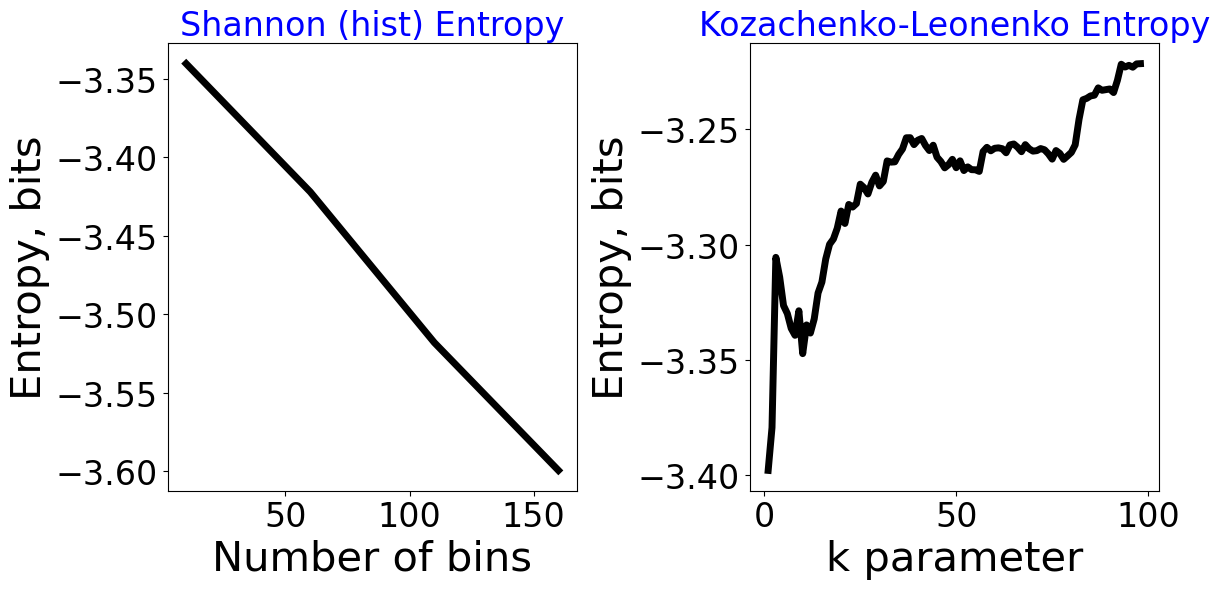

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

## KL entropy 
ks = list(range(1, 99))
s = []

npts = len(x)
z = np.array(x).reshape(npts, 1)
    
for k in ks:
    entropy = kozachenko_leonenko_entropy(z, k)
    s.append(entropy/np.log(2))

axes[1].plot(ks, s, lw=5, color="black")
axes[1].set_title("Kozachenko-Leonenko Entropy", color="blue")
axes[1].set_xlabel('k parameter', fontsize=30)
axes[1].set_ylabel('Entropy, bits', fontsize=30)

# Histogram entropy
bins_list = np.arange(10, 200, 50)
entropy_list = []

for bins in bins_list:
    counts, bin_edges = np.histogram(x, bins=bins, density=True)
    dx = bin_edges[1] - bin_edges[0]
    p = counts[counts > 0]
    entropy = -np.sum(p * np.log(p)) * dx
    entropy_list.append(entropy/np.log(2))

axes[0].plot(bins_list, entropy_list, lw=5, color="black")
axes[0].set_title("Shannon (hist) Entropy", color="blue")
axes[0].set_xlabel('Number of bins', fontsize=30)
axes[0].set_ylabel('Entropy, bits', fontsize=30)

plt.tight_layout()
